In [1]:
import sys
sys.path.insert(0, "../")

import numpy as np
import matplotlib.pyplot as plt
from time import time
from astropy.table import Table

from sklearn.datasets import load_iris
from mcfa import (mcfa, mpl_utils, utils)

%matplotlib inline

In [2]:
GALAH_CATALOG_PATH = "../catalogs/GALAH_DR2.1_catalog.fits"
#galah = fits.open(GALAH_CATALOG_PATH)[1].data
galah = Table.read(GALAH_CATALOG_PATH)

In [3]:
D = 15
N = 1000 # subsample the data for testing

np.random.seed(42)

element_label_names = [ln for ln in galah.dtype.names if ln.endswith("_fe") and not ln.startswith(("flag_", "e_", "alpha_"))]
print("\n".join(element_label_names))

# Select a subset of stars and abundances
is_ok = dict()
for label_name in element_label_names:
    is_ok[label_name] = sum(galah["flag_{}".format(label_name)] == 0)

import operator
for k, v in sorted(is_ok.items(), key=operator.itemgetter(1))[::-1]:
    print(k, v)
    
use_element_label_names = [k for k, v in sorted(is_ok.items(), key=operator.itemgetter(1))[::-1]][:D - 1]

# Add in Eu.
use_element_label_names.append("eu_fe")

meets_qc = (galah["flag_cannon"] == 0)
print(sum(meets_qc))
for label_name in use_element_label_names:
    meets_qc *= (galah["flag_{}".format(label_name)] == 0) \
              * (np.isfinite(galah[label_name]))
    print(label_name, sum(meets_qc))

use_element_label_names.append("fe_h")
    


X = np.array([galah[ln][meets_qc] for ln in use_element_label_names]).T

print("Sub-sampling {} stars (from {})".format(N, X.shape[0]))
idx = np.random.choice(X.shape[0], N, replace=False)
X = X[idx]
    

fe_h_index = list(use_element_label_names).index("fe_h")
for d in range(D):
    if d == fe_h_index: continue
    X[:, d] += X[:, fe_h_index]
    
    
label_names = np.array(["{}_h".format(ea.split("_")[0]) for ea in use_element_label_names])
    
N, D = X.shape
assert N > D
assert np.all(np.isfinite(X))

li_fe
c_fe
o_fe
na_fe
mg_fe
al_fe
si_fe
k_fe
ca_fe
sc_fe
ti_fe
v_fe
cr_fe
mn_fe
co_fe
ni_fe
cu_fe
zn_fe
y_fe
ba_fe
la_fe
eu_fe
na_fe 265806
mg_fe 264551
sc_fe 251749
ti_fe 250655
zn_fe 248993
mn_fe 247222
y_fe 244475
ca_fe 240420
ni_fe 235944
cr_fe 235783
o_fe 230613
si_fe 228337
k_fe 214247
ba_fe 206675
v_fe 184428
cu_fe 184380
al_fe 178739
la_fe 52715
eu_fe 42901
c_fe 29126
co_fe 18332
li_fe 3963
264227
na_fe 239580
mg_fe 226436
sc_fe 209213
ti_fe 195146
zn_fe 179550
mn_fe 169286
y_fe 155500
ca_fe 146109
ni_fe 134787
cr_fe 125124
o_fe 111499
si_fe 101675
k_fe 86929
ba_fe 77881
eu_fe 7984
Sub-sampling 1000 stars (from 7984)


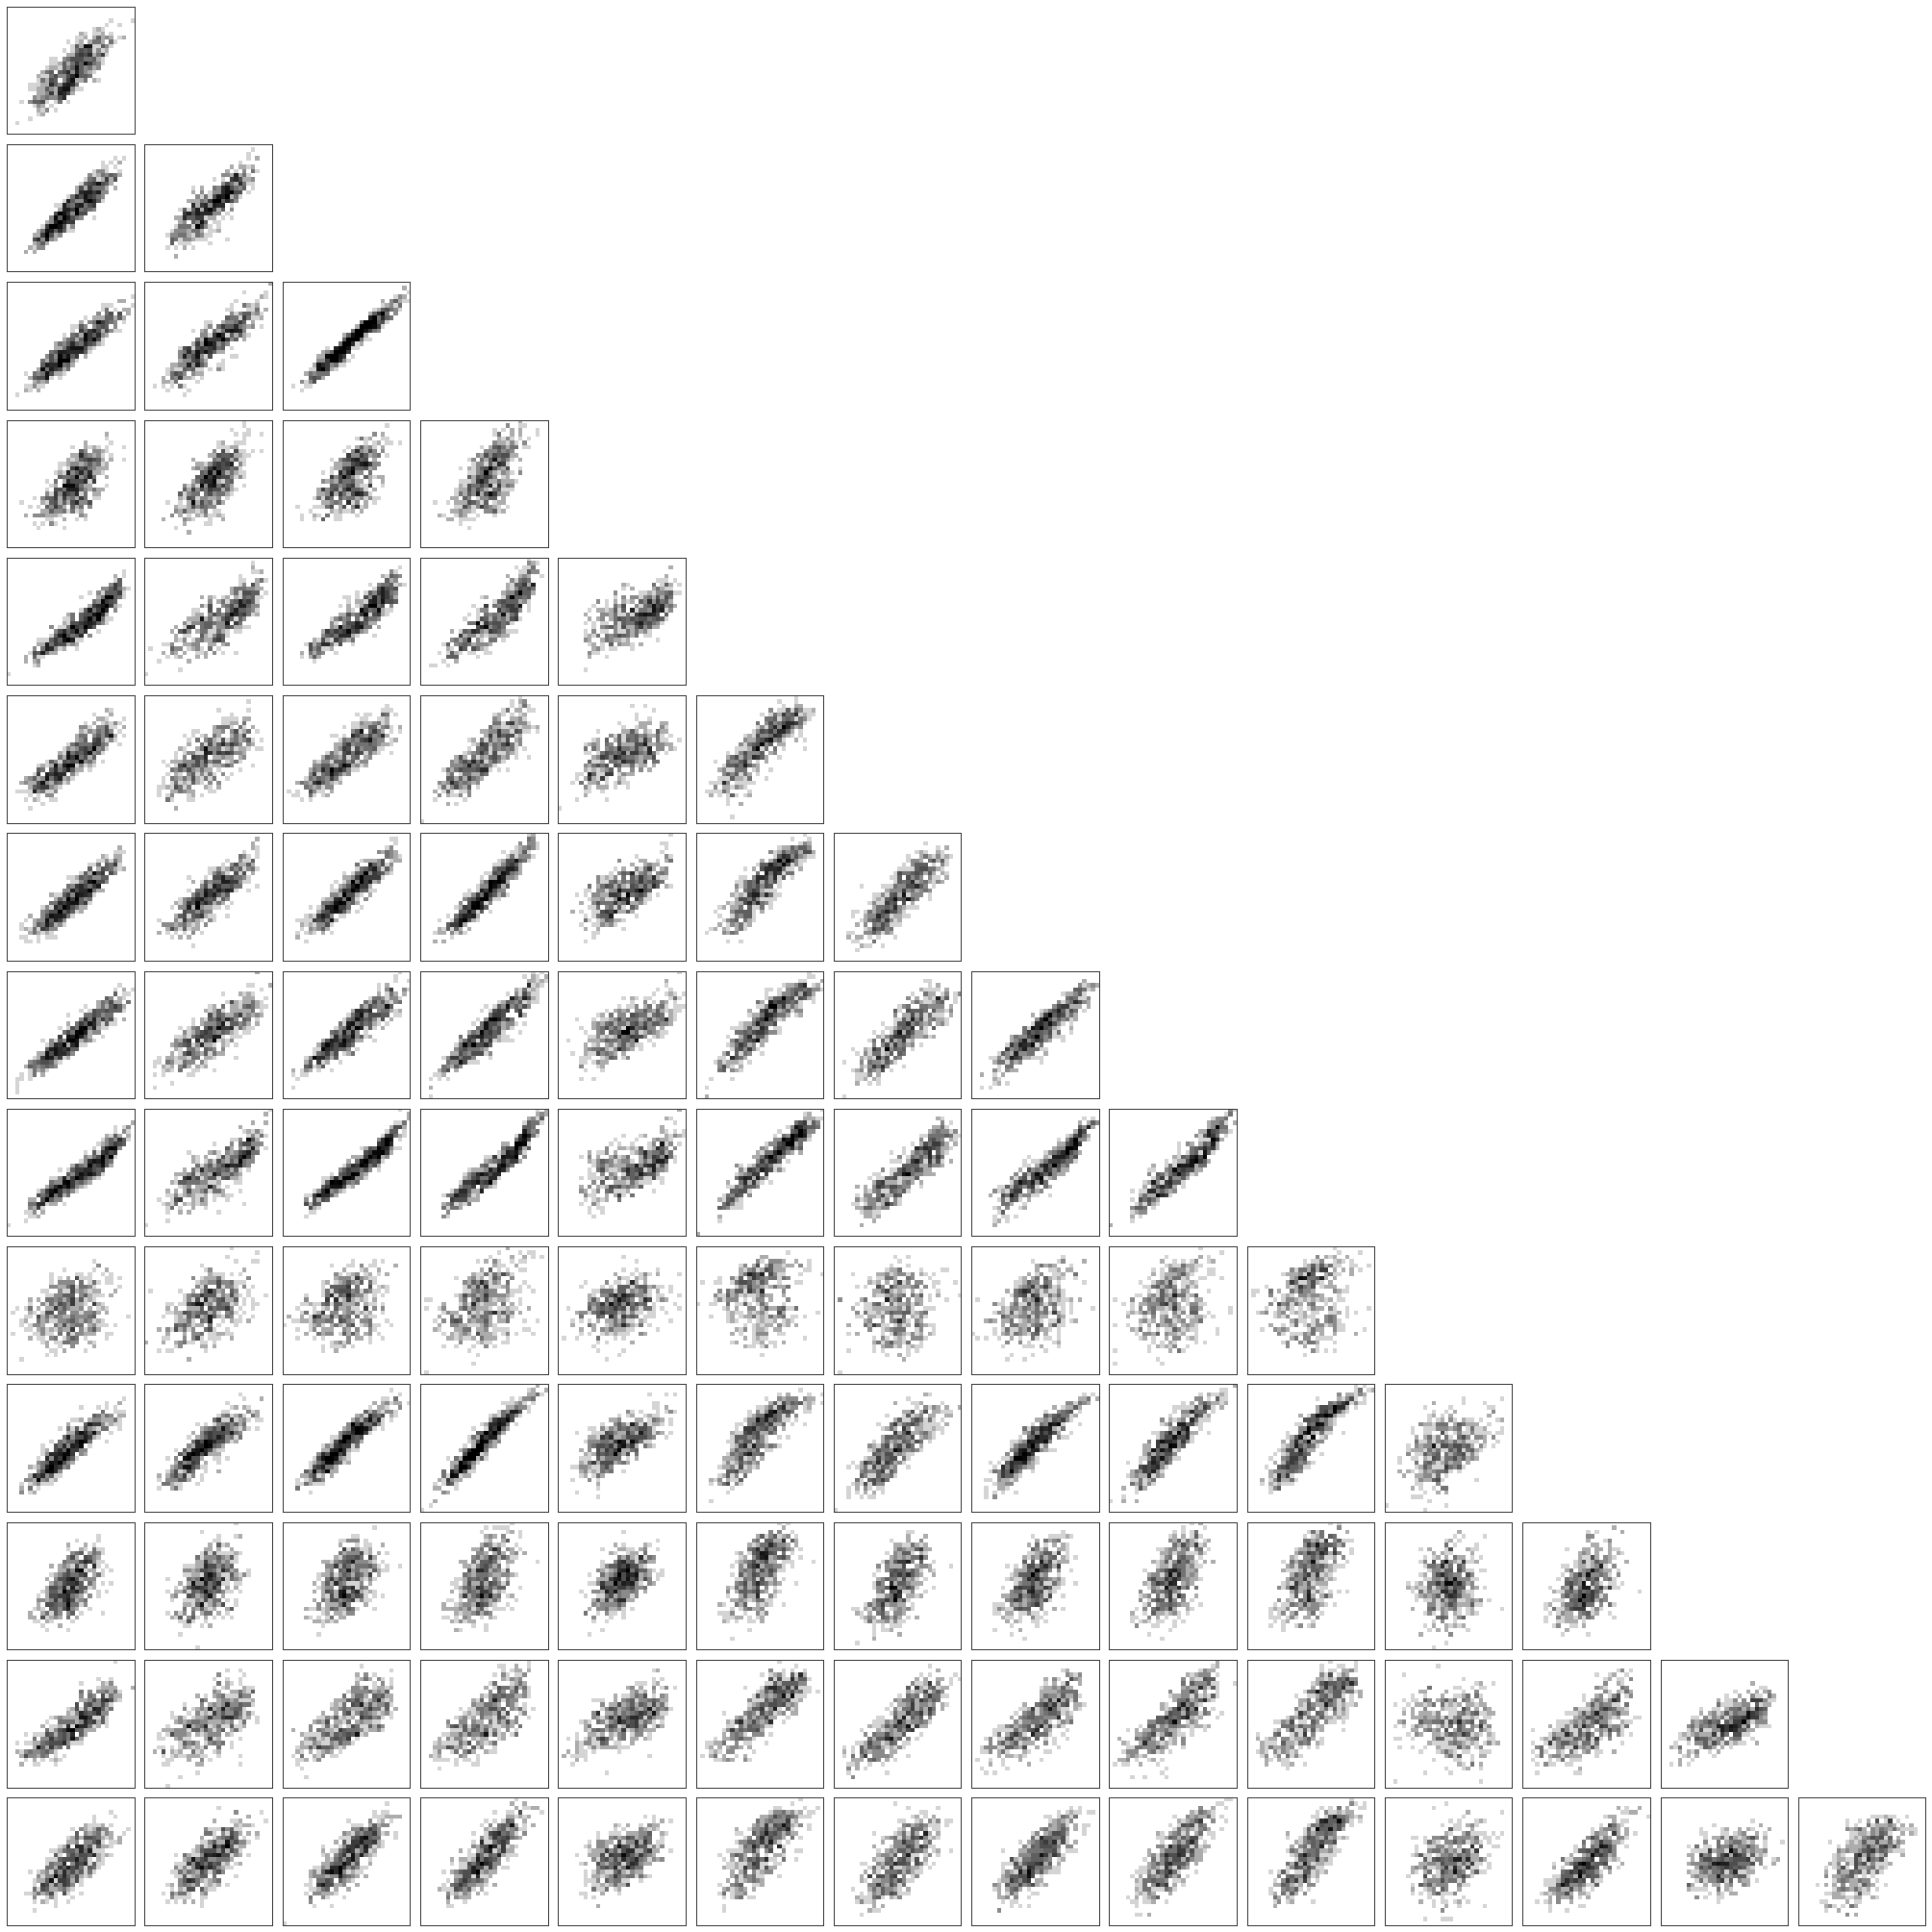

In [4]:
fig = mpl_utils.corner_hist(X)

In [5]:
J = 3 # number of latent factors
K = 5 # number of clusters

t_init = time()

model = mcfa.MCFA(n_latent_factors=J, n_components=K, n_init=1)
model.fit(X)

t_opt = time() - t_init

print("Took {:.0f}s to optimize. ll = {:.0f}".format(t_opt, model.log_likelihood_))

Took 1s to optimize. ll = 13066


In [14]:
model.log_likelihood_

13065.791559134444

In [6]:
for parameter_name, value in dict(zip(model.parameter_names, model.theta_)).items():
    print("{}: {}\n{}".format(parameter_name, value.shape, value))

pi: (5,)
[0.12624302 0.09866238 0.19765198 0.3695355  0.20790712]
A: (16, 3)
[[-0.24855105  0.04766867 -0.03132621]
 [-0.15029438 -0.07256872  0.24735904]
 [-0.25164803  0.12290348  0.19994164]
 [-0.23185021 -0.10742071  0.25775628]
 [-0.17313591  0.09857153  0.0319637 ]
 [-0.37252337  0.47654441 -0.21507658]
 [-0.29880904 -0.04232274 -0.17799698]
 [-0.20678723 -0.03730737  0.11750351]
 [-0.32603153 -0.61431411  0.05674413]
 [-0.34836641  0.30261211  0.0253126 ]
 [-0.04983818 -0.09309048  0.47525259]
 [-0.23193093 -0.11556868  0.28626984]
 [-0.10737924 -0.14678159 -0.18946474]
 [-0.29717034 -0.35712    -0.58678881]
 [-0.16808659 -0.08796481  0.21552154]
 [-0.292797    0.2793346   0.01743572]]
xi: (3, 5)
[[-1.16082314  0.74501749 -0.6438444   0.94865452 -0.02799105]
 [-0.38752954 -0.21809822 -0.28235851 -0.25739874 -0.28188505]
 [ 0.15121009 -0.2045848  -0.03270471  0.1760605  -0.16483952]]
omega: (3, 3, 5)
[[[ 8.56828942e-02  9.69230803e-02  8.17958782e-02  3.66993533e-01
    7.8832048

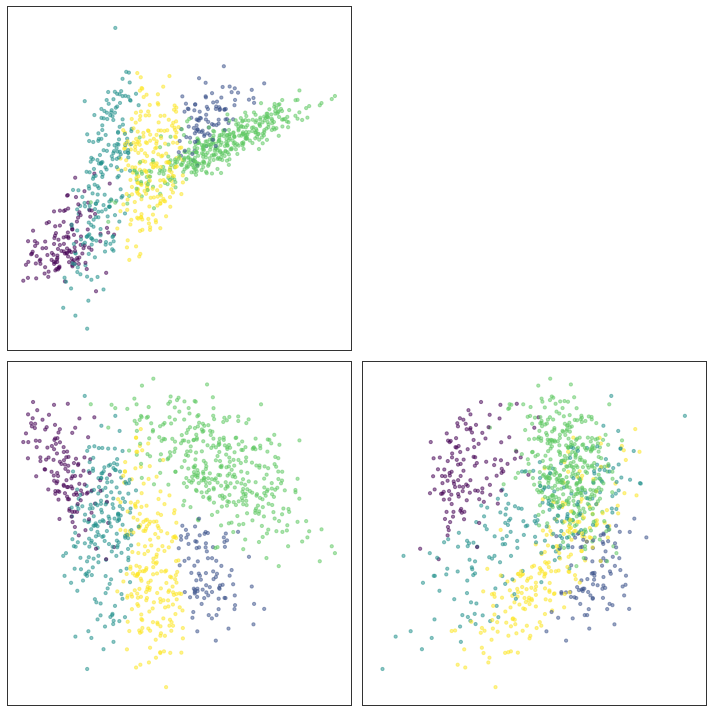

In [7]:
# Plot the estimated posterior factor scores.
#fig = mpl_utils.corner_scatter(X, s=10, alpha=0.75, figsize=(10, 10))
v, v_cluster, v_mean = model.factor_scores(X)

# Associations
hard_associations = np.argmax(model.tau_, axis=1)

fig = mpl_utils.corner_scatter(v_mean, c=hard_associations, figsize=(10, 10), s=10)

(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)


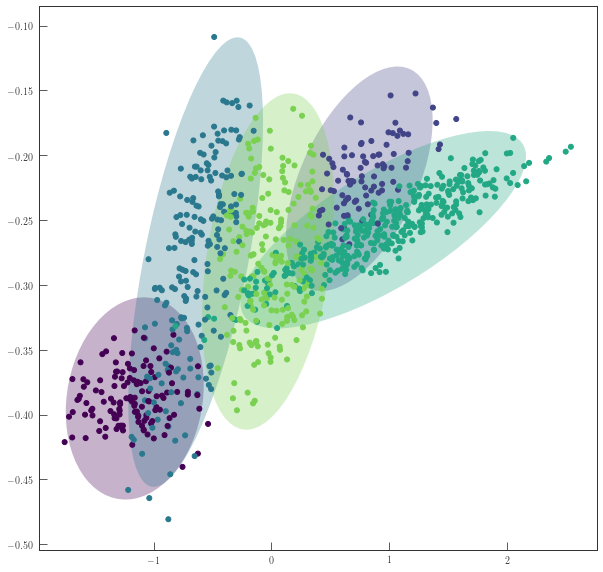

In [8]:
from matplotlib.patches import Ellipse


fig, ax = plt.subplots(figsize=(10, 10))
scat = ax.scatter(v_cluster.T[0], v_cluster.T[1],
                  c=hard_associations, vmin=0, vmax=model.n_components)

cmap = scat.get_cmap()

mus = model.theta_[model.parameter_names.index("xi")]
covs = model.theta_[model.parameter_names.index("omega")]

for i, (mu, cov) in enumerate(zip(mus.T, covs.T)):
    
    print(cov.shape)
    cov_ = cov[:2, :2]
    vals, vecs = np.linalg.eigh(cov_)
    order = vals.argsort()[::-1]
    vals = vals[order][:2]
    vecs = vecs[:, order][:2]
    
    theta = np.degrees(np.arctan2(*vecs[:, 0][::-1]))
    
    color = scat.to_rgba(i)
    
    width, height = 2.0 * 2 * np.sqrt(vals)
    ellipse = Ellipse(xy=mu[:2], width=width, height=height, angle=theta,
                      facecolor=color, zorder=-1, alpha=0.3)
    ax.add_artist(ellipse)
    

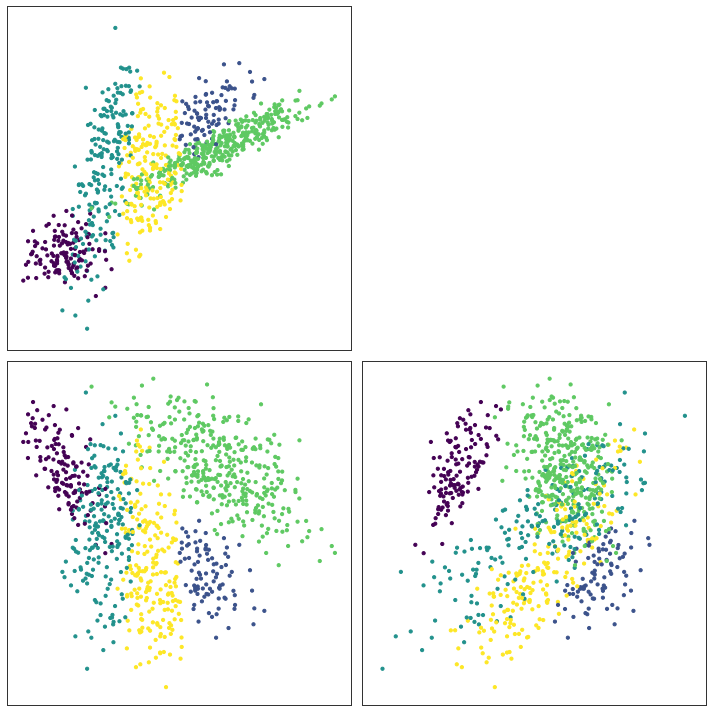

In [9]:
fig = mpl_utils.corner_scatter(v_cluster, c=hard_associations, figsize=(10, 10), alpha=1, s=10)

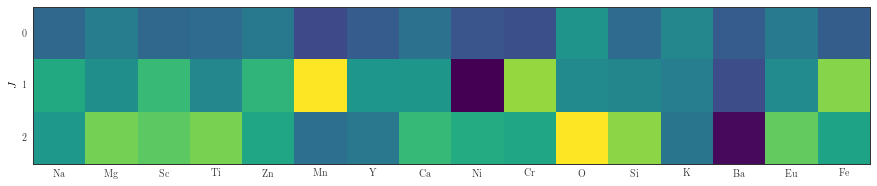

In [10]:
# Plot loads?
factor_loads = model.theta_[model.parameter_names.index("A")].T

fig, ax = plt.subplots(figsize=(15, 6))
im = ax.imshow(factor_loads, interpolation="nearest")
ax.yaxis.set_tick_params(width=0)
ax.xaxis.set_tick_params(width=0)
ax.set_yticks(np.arange(model.n_latent_factors))
ax.set_ylabel(r"$J$")

ax.set_xticks(np.arange(D))
_ = ax.set_xticklabels([r"\textrm{{{0}}}".format(e.split("_")[0].title()) \
                    for e in label_names])

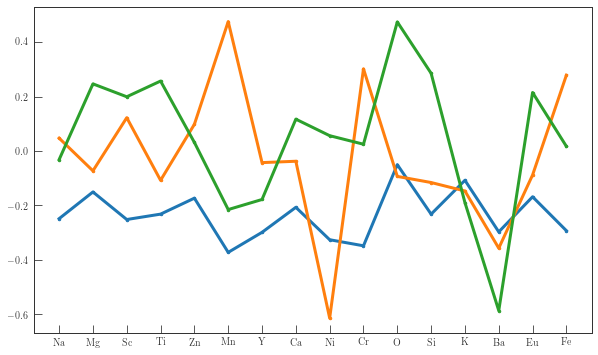

In [11]:
fig, ax = plt.subplots(figsize=(10, 6))
for j in range(model.n_latent_factors):
    ax.plot(factor_loads[j], lw=3)
ax.set_xticks(range(D))
ax.set_xticklabels([r"\textrm{{{0}}}".format(e.split("_")[0].title()) \
                    for e in label_names])

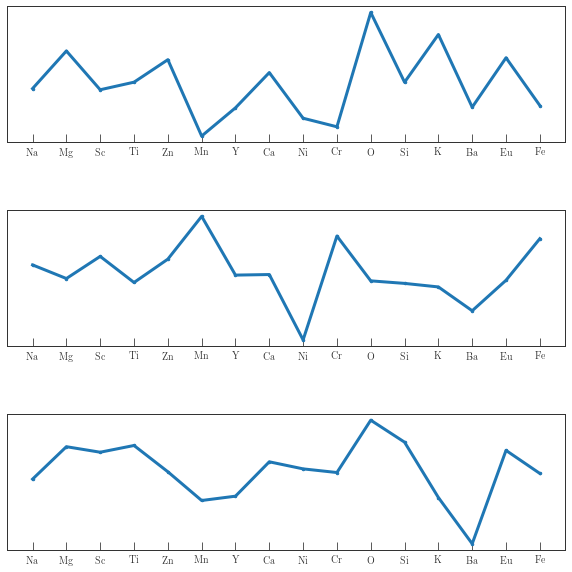

In [12]:
fig, axes = plt.subplots(model.n_latent_factors, 1, figsize=(10, 10))
for j, ax in enumerate(axes):
    ax.plot(factor_loads[j], lw=3)
    ax.set_xticks(range(D))
    ax.set_xticklabels([r"\textrm{{{0}}}".format(e.split("_")[0].title()) \
                        for e in label_names])
    
    ax.set_yticks([])

In [19]:
# Group by "physics"
light_odd_z = ["Na", "K"]
fe_peak = ["Sc", "Cr", "Mn", "Fe", "Ni", "Zn"]
s_process = ["Y", "Ba"]
alpha = ["O", "Mg", "Si", "Ca", "Ti"]
r_process = ["Eu"]

ordered_label_names = light_odd_z \
                    + alpha \
                    + fe_peak \
                    + s_process \
                    + r_process

# ordered label indices
oli = np.array([list(label_names).index("{}_h".format(_.lower())) for _ in ordered_label_names])


assert len(set(ordered_label_names)) == len(set(label_names))



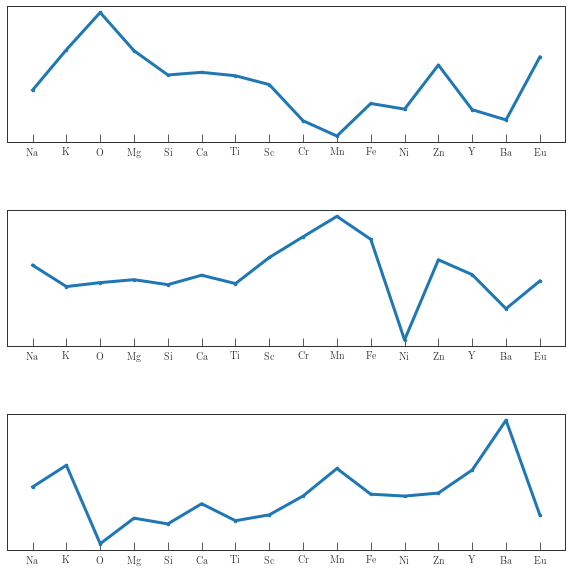

In [23]:
fig, axes = plt.subplots(model.n_latent_factors, 1, figsize=(10, 10))
for j, ax in enumerate(axes):
    ax.plot(factor_loads[j][oli], lw=3)
    ax.set_xticks(range(D))
    ax.set_xticklabels([r"\textrm{{{0}}}".format(e.split("_")[0].title()) \
                        for e in label_names[oli]])
    
    ax.set_yticks([])